# Lesion segmentation in MRI Scans for Multiple Sclerosis disease

**Author & Credentials**

Author: *inż. Witold Synowiec*
Thesis supervisor: *dr. inż. Robert Kurjata*
University: Warsaw *University of Technology*
Faculty: *Faculty of Electronics and Information Technology*

## Introduction

The idea for the tool is to accelerate diagnosis via automizing the initial analysis for Multiple Sclerosis.

Multiple Sclerosis (MS) is a chronic disease affecting central nervous system, more specifically the myelin tissue surrounding nerve fibers. The outcome of the loss in the insulation that is preventing certain nerves to conduct properly electric impulses from the brain. From there on the disease may manifest in wide range of ways, muting affected person, preventing them from walking, holding things firm in their arms, triggering pain attacks and many more. Not treated properly or not diagnosed early enough, the disease may cause serious disability. The only way to make a diagnosis early, apart from observing relapses are the brain lesions seen in MRI scan. In fact, certain combination of this two mentioned measures, are used by most common used McDonald criteria for diagnosis of MS. For the reason of making a halt to disease progression early the tool to automate segmentation of lesions is being proposed. The tool is based on Convolutional Neural Network, which is trained for segmenting those lesions.

## The Dataset early processing

The dataset is stored in compressed nifti files (.nii.gz) which need to be unpacked. What's more the images are stored in different directories, which invokes necessity for some initial processing. The method used for this cause are implemented in FilesHelpers/FilesHelper.py. These are not smart methods, as the sources of data may be stored differently, so it's implemented for authors usage only.

What is important is a fact, that for training there need to be folders, one that stores slices from image as one channel 2D arrays in .npy files each slices named a number for example "452.npy". Similarly, the masks must be stored in separate folder each one channel slice named by number and _mask added to the end of the name for example "452_mask.npy". The connection between slice and mask is given by name number.

The method initiate_dataset() is making just that for authors dataset.

In [3]:
import torchgeometry as torchgeometry
import torchvision.transforms

from FilesHelpers import FilesHelper
FilesHelper.initiate_dataset()

Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii. Image: (1, 158, 158), Mask: (1, 158, 158)
Shape of 0.nii

## Performing the Loader

## Colab optional

## Performing The Training

In [1]:
import torch
print('Pytorch CUDA Version is', torch.version.cuda)
print('Is CUDA supported by system:', torch.cuda.is_available())
print('CUDA Device ID: ', torch.cuda.current_device())
print('Name of the current CUDA Device:', torch.cuda.get_device_name(torch.cuda.current_device()))

Pytorch CUDA Version is 12.1
Is CUDA supported by system: True
CUDA Device ID:  0
Name of the current CUDA Device: NVIDIA GeForce RTX 3060 Ti


In [3]:
# Setting hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 50
SPLIT_RATIO = (0.8, 0.2)
SHUFFLE = True
IMAGE_SIZE = (128, 128)
NUM_WORKERS = 4

In [4]:
from Segmentation.Trainer.train import fit
from Segmentation.model import UNet
from Segmentation.dataset import MSDataset
from torchvision.transforms import InterpolationMode, Compose, Resize
from Segmentation.losses.loss import FocalLoss
from Segmentation.utils import load_state
from torch import optim
import torchgeometry
import torch.nn as nn
import torch
import numpy as np
import math
import os

torch.cuda.empty_cache()

# Initiating model
model = UNet(initial_in_channels=1, initial_out_channels=1)
# tar_file = torch.load("results/24-11-2023_21-46/epoch_20/epoch_20.pth")
# load_state(tar_file, model)
 
# Initiating dataset
dataset = MSDataset(
    image_dir=r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/images/',
    mask_dir=r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/annotations/',
    transform=Compose([
        Resize(size=IMAGE_SIZE, interpolation=InterpolationMode.BILINEAR, antialias=False),
    ]),
    target_transform=Compose([
        Resize(size=IMAGE_SIZE, interpolation=InterpolationMode.NEAREST, antialias=False)
    ])
)

# Initiating optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
op = optim.
# Initializing scaler
scaler = torch.cuda.amp.GradScaler()

# Initializing loss function
weight = np.sqrt(590002975.0 / 1480241.0)

weights = torch.tensor(np.array([[[weight]]])).to(torch.device('cuda'))
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights)

# Training
fit(
    model=model,
    dataset=dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scaler=scaler,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    split_ratio=SPLIT_RATIO,
    shuffle=SHUFFLE,
    save_all_states=False,
    num_workers=NUM_WORKERS,
    initial_epoch=0
)


Using cuda processor
Using NVIDIA GeForce RTX 3060 Ti device.
Initiating training process...
=> Saving metadata
Epoch 1 of 50
Cuda memory allocated : 73.57811326474032%


100%|██████████| 2212/2212 [01:35<00:00, 23.05it/s, loss=0.028] 

Mean loss equals 0.01403054030893845
Calculating metrics...



/home/user/.virtualenvs/LesionSegmentation/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Appending metrics...

Epoch 2 of 50
Cuda memory allocated : 86.08665051622998%


100%|██████████| 2212/2212 [01:34<00:00, 23.46it/s, loss=0.00909]

Mean loss equals 0.003279346893189874
Calculating metrics...


Appending metrics...

Epoch 3 of 50
Cuda memory allocated : 68.12441334482828%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=0.0242] 

Mean loss equals 0.002354418600228186
Calculating metrics...


Appending metrics...

Epoch 4 of 50
Cuda memory allocated : 89.63360086671725%


100%|██████████| 2212/2212 [01:34<00:00, 23.42it/s, loss=0.0123]  

Mean loss equals 0.001993491940577422
Calculating metrics...


Appending metrics...

Epoch 5 of 50
Cuda memory allocated : 72.59856169779681%


100%|██████████| 2212/2212 [01:34<00:00, 23.37it/s, loss=0.0095]  

Mean loss equals 0.001764512400495095
Calculating metrics...


Appending metrics...

Epoch 6 of 50
Cuda memory allocated : 91.7350724543026%


100%|██████████| 2212/2212 [01:36<00:00, 22.96it/s, loss=0.00448] 

Mean loss equals 0.0015883329112544697
Calculating metrics...


Appending metrics...

Epoch 7 of 50
Cuda memory allocated : 78.35054469045379%


100%|██████████| 2212/2212 [01:34<00:00, 23.37it/s, loss=0.0165]  

Mean loss equals 0.0014428019823193314
Calculating metrics...


Appending metrics...

Epoch 8 of 50
Cuda memory allocated : 93.13337887984501%


100%|██████████| 2212/2212 [01:34<00:00, 23.39it/s, loss=0.00104] 

Mean loss equals 0.0013460514337496651
Calculating metrics...


Appending metrics...

Epoch 9 of 50
Cuda memory allocated : 82.52342285906143%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.0253]  

Mean loss equals 0.0012246762368925213
Calculating metrics...


Appending metrics...

Epoch 10 of 50
Cuda memory allocated : 94.124319902504%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.0149]  

Mean loss equals 0.0011393153948908807
Calculating metrics...


Appending metrics...
Epoch 10 saving checkpoint
Current duration of training [hh:mm:ss]: 0:19:58.642589
=> Saving state
=> Saving metrics
=> Saving losses

Epoch 11 of 50
Cuda memory allocated : 83.153328890282%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=0.00555] 

Mean loss equals 0.0010737907545953216
Calculating metrics...


Appending metrics...

Epoch 12 of 50
Cuda memory allocated : 94.85797748526166%


100%|██████████| 2212/2212 [01:34<00:00, 23.31it/s, loss=0.0125]  

Mean loss equals 0.0010100196581871183
Calculating metrics...


Appending metrics...

Epoch 13 of 50
Cuda memory allocated : 88.47299038940201%


100%|██████████| 2212/2212 [01:35<00:00, 23.27it/s, loss=0.0088]  

Mean loss equals 0.0009486936552338648
Calculating metrics...


Appending metrics...

Epoch 14 of 50
Cuda memory allocated : 95.44011984554236%


100%|██████████| 2212/2212 [01:34<00:00, 23.41it/s, loss=0.00287] 

Mean loss equals 0.0009088400083795537
Calculating metrics...


Appending metrics...

Epoch 15 of 50
Cuda memory allocated : 89.68393222169657%


100%|██████████| 2212/2212 [01:34<00:00, 23.42it/s, loss=0.0132]  

Mean loss equals 0.0008573185961337898
Calculating metrics...


Appending metrics...

Epoch 16 of 50
Cuda memory allocated : 95.90142615997789%


100%|██████████| 2212/2212 [01:34<00:00, 23.41it/s, loss=0.0032]  

Mean loss equals 0.0008188731152586732
Calculating metrics...


Appending metrics...

Epoch 17 of 50
Cuda memory allocated : 23.994333014106033%


100%|██████████| 2212/2212 [01:34<00:00, 23.40it/s, loss=0.00289] 

Mean loss equals 0.0007783687922137685
Calculating metrics...


Appending metrics...

Epoch 18 of 50
Cuda memory allocated : 33.50002440489916%


100%|██████████| 2212/2212 [01:34<00:00, 23.37it/s, loss=0.00291] 

Mean loss equals 0.0007570221609433514
Calculating metrics...


Appending metrics...

Epoch 19 of 50
Cuda memory allocated : 33.5064874954346%


100%|██████████| 2212/2212 [01:34<00:00, 23.41it/s, loss=0.00557] 

Mean loss equals 0.0007230772213115156
Calculating metrics...


Appending metrics...

Epoch 20 of 50
Cuda memory allocated : 43.0229507037868%


100%|██████████| 2212/2212 [01:34<00:00, 23.40it/s, loss=0.00412] 

Mean loss equals 0.0006865677099762825
Calculating metrics...


Appending metrics...
Epoch 20 saving checkpoint
Current duration of training [hh:mm:ss]: 0:40:01.812491
=> Saving state
=> Saving metrics
=> Saving losses

Epoch 21 of 50
Cuda memory allocated : 33.48709822382827%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=0.00413] 


Mean loss equals 0.0006652464130042369
Calculating metrics...
Appending metrics...

Epoch 22 of 50
Cuda memory allocated : 33.5215680400173%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=4.74e-5] 

Mean loss equals 0.0006323320642098535
Calculating metrics...


Appending metrics...

Epoch 23 of 50
Cuda memory allocated : 43.055266156464015%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=0.00497] 

Mean loss equals 0.0006131699525469171
Calculating metrics...


Appending metrics...

Epoch 24 of 50
Cuda memory allocated : 43.0531117929522%


100%|██████████| 2212/2212 [01:34<00:00, 23.46it/s, loss=0.00446] 

Mean loss equals 0.0005880265735263656
Calculating metrics...


Appending metrics...

Epoch 25 of 50
Cuda memory allocated : 52.558803183745326%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.00806] 

Mean loss equals 0.0005638538945056157
Calculating metrics...


Appending metrics...

Epoch 26 of 50
Cuda memory allocated : 43.035876884857686%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.0061]  

Mean loss equals 0.000546462120112229
Calculating metrics...


Appending metrics...

Epoch 27 of 50
Cuda memory allocated : 52.55234009320988%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=7.88e-5] 

Mean loss equals 0.0005278307607779499
Calculating metrics...


Appending metrics...

Epoch 28 of 50
Cuda memory allocated : 43.01648761325135%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.00823] 

Mean loss equals 0.0005104693670314061
Calculating metrics...


Appending metrics...

Epoch 29 of 50
Cuda memory allocated : 43.05095742944039%


100%|██████████| 2212/2212 [01:34<00:00, 23.43it/s, loss=0.00238] 

Mean loss equals 0.0004966737085875345
Calculating metrics...


Appending metrics...

Epoch 30 of 50
Cuda memory allocated : 52.5846555458871%


100%|██████████| 2212/2212 [01:34<00:00, 23.44it/s, loss=0.00088] 

Mean loss equals 0.00047468672109957126
Calculating metrics...


Appending metrics...
Epoch 30 saving checkpoint
Current duration of training [hh:mm:ss]: 0:59:57.058760
=> Saving state
=> Saving metrics
=> Saving losses

Epoch 31 of 50
Cuda memory allocated : 52.58250118237528%


100%|██████████| 2212/2212 [01:34<00:00, 23.47it/s, loss=0.000467]

Mean loss equals 0.0004599299533514516
Calculating metrics...


Appending metrics...

Epoch 32 of 50
Cuda memory allocated : 62.08819257316841%


100%|██████████| 2212/2212 [01:34<00:00, 23.46it/s, loss=0.00181] 

Mean loss equals 0.00044841252188781105
Calculating metrics...


Appending metrics...

Epoch 33 of 50
Cuda memory allocated : 62.094655663703854%


100%|██████████| 2212/2212 [01:34<00:00, 23.48it/s, loss=0.00307] 

Mean loss equals 0.0004328517341880891
Calculating metrics...


Appending metrics...

Epoch 34 of 50
Cuda memory allocated : 71.61111887205605%


100%|██████████| 2212/2212 [01:34<00:00, 23.45it/s, loss=0.012]   


Mean loss equals 0.0004156479889194761
Calculating metrics...
Appending metrics...

Epoch 35 of 50
Cuda memory allocated : 71.6046557815206%


100%|██████████| 2212/2212 [01:34<00:00, 23.46it/s, loss=0.00327] 

Mean loss equals 0.00040846298852655787
Calculating metrics...


Appending metrics...

Epoch 36 of 50
Cuda memory allocated : 81.16851498713272%


100%|██████████| 2212/2212 [01:34<00:00, 23.45it/s, loss=0.00192] 

Mean loss equals 0.0003966748131643927
Calculating metrics...


Appending metrics...

Epoch 37 of 50
Cuda memory allocated : 81.17282371415637%


100%|██████████| 2212/2212 [01:34<00:00, 23.45it/s, loss=0.00835] 


Mean loss equals 0.00038238621647477313
Calculating metrics...
Appending metrics...

Epoch 38 of 50
Cuda memory allocated : 90.70005874006762%


100%|██████████| 2212/2212 [01:34<00:00, 23.47it/s, loss=1.23e-6] 

Mean loss equals 0.0003700073732790578
Calculating metrics...


Appending metrics...

Epoch 39 of 50
Cuda memory allocated : 90.66854742102835%


100%|██████████| 2212/2212 [01:34<00:00, 23.46it/s, loss=0.01]    

Mean loss equals 0.0003593340611009521
Calculating metrics...


Appending metrics...

Epoch 40 of 50
Cuda memory allocated : 96.27016168965491%


100%|██████████| 2212/2212 [01:34<00:00, 23.47it/s, loss=0.000576]


Mean loss equals 0.00035513251912363603
Calculating metrics...
Appending metrics...
Epoch 40 saving checkpoint
Current duration of training [hh:mm:ss]: 1:19:51.952247
=> Saving state
=> Saving metrics
=> Saving losses

Epoch 41 of 50
Cuda memory allocated : 91.48164487987299%


100%|██████████| 2212/2212 [01:36<00:00, 22.93it/s, loss=0.00349] 


Mean loss equals 0.0003411000496826702
Calculating metrics...
Appending metrics...

Epoch 42 of 50
Cuda memory allocated : 96.58765719313054%


100%|██████████| 2212/2212 [01:36<00:00, 22.83it/s, loss=0.00197] 

Mean loss equals 0.0003338021524875692
Calculating metrics...


Appending metrics...

Epoch 43 of 50
Cuda memory allocated : 92.20031896979542%


100%|██████████| 2212/2212 [01:36<00:00, 22.85it/s, loss=3.28e-6] 

Mean loss equals 0.00032368483046636053
Calculating metrics...


Appending metrics...

Epoch 44 of 50
Cuda memory allocated : 96.85274389741873%


100%|██████████| 2212/2212 [01:35<00:00, 23.17it/s, loss=0.0068]  

Mean loss equals 0.0003201760973118394
Calculating metrics...


Appending metrics...

Epoch 45 of 50
Cuda memory allocated : 88.72929657345497%


100%|██████████| 2212/2212 [01:34<00:00, 23.33it/s, loss=2.69e-6] 


Mean loss equals 0.0003065033434066806
Calculating metrics...
Appending metrics...

Epoch 46 of 50
Cuda memory allocated : 96.47157783737113%


100%|██████████| 2212/2212 [01:35<00:00, 23.10it/s, loss=0.00737] 

Mean loss equals 0.00030620053965775475
Calculating metrics...


Appending metrics...

Epoch 47 of 50
Cuda memory allocated : 86.4449097804652%


100%|██████████| 2212/2212 [01:35<00:00, 23.22it/s, loss=0.0004]  

Mean loss equals 0.0002935961746985306
Calculating metrics...


Appending metrics...

Epoch 48 of 50
Cuda memory allocated : 86.45339588298062%


100%|██████████| 2212/2212 [01:35<00:00, 23.21it/s, loss=0.00674] 

Mean loss equals 0.00028543650040545424
Calculating metrics...


Appending metrics...

Epoch 49 of 50
Cuda memory allocated : 93.95221992795432%


100%|██████████| 2212/2212 [01:35<00:00, 23.20it/s, loss=1.03e-6] 

Mean loss equals 0.00027963681714870264
Calculating metrics...


Caught CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 7.05 GiB is allocated by PyTorch, and 271.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF exception. Continuing from saved model


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 7.08 GiB is allocated by PyTorch, and 235.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Loading data

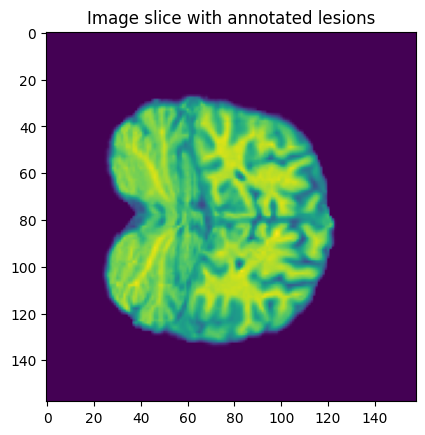

(232, 158, 158)


In [8]:
import os
from FilesHelpers.Nifti import Nifti

dataset_path = input("Input a path to dataset:") or r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/zenodo'

image = Nifti(os.path.join(dataset_path,"shifts_ms_pt1","shifts_ms_pt1","msseg","dev_in","t1","4_T1_isovox.nii"), os.path.join(dataset_path,"shifts_ms_pt1","shifts_ms_pt1","msseg","dev_in","gt","4_gt_isovox.nii"))

image.preview(slice_number=170, show_data_slice=True, show_annotation_slice=True)

Using NVIDIA GeForce RTX 3060 Ti device.
=> Loading state
(1, 1, 176, 176)


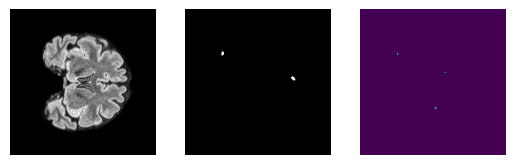

In [5]:
import torch
from Segmentation.model import UNet
from Segmentation.utils import load_state
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using {} device.".format(torch.cuda.get_device_name(device)))
model = UNet(initial_in_channels=1, initial_out_channels=1).to(device)

tar_file = torch.load(input("Path to file") or "results/12-12-2023_16-16/epoch_40/epoch_40.pth")
load_state(tar_file, model)

model.eval()

no  = input("The number of slice from dataset") or "4556"

img = np.expand_dims(np.load(r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/images/{}.npy'.format(no)), axis=0)
mask = np.expand_dims(np.load(r'/mnt/c/Users/pegaz/Desktop/Praca-Magisterska/dataset/organized/annotations/{}_mask.npy'.format(no)), axis=0)

print(img.shape)
mask_pred = (torch.sigmoid(model(torch.from_numpy(img).float().to(device)) > 0.5).float()).cpu().detach().numpy().squeeze(0).squeeze(0)

img = img.squeeze(0).squeeze(0)
mask = mask.squeeze(0).squeeze(0)
model.train()

Image.fromarray(img, 'L').save("img.jpeg")
Image.fromarray(mask, 'L').save("mask.jpeg")
Image.fromarray(mask_pred, 'L').save("mask_pred.jpeg")


fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(mask, cmap='gray')
axs[2].imshow(mask_pred)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()

